In [1]:
import opendatasets as od

In [2]:
od.download("https://www.kaggle.com/datasets/haqishen/rsna-cropped-2d-224-0920-2m")

Skipping, found downloaded files in "./rsna-cropped-2d-224-0920-2m" (use force=True to force download)


In [25]:
import torch
device = torch.device('cuda:1')

In [26]:
DEBUG = False

In [27]:
import os
import sys
import gc
import ast
import cv2
import time
import timm
import pickle
import random
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

%matplotlib inline
rcParams['figure.figsize'] = 20, 8

#device=torch.cuda.set_device(1)
torch.backends.cudnn.benchmark = True

## Config

In [28]:
kernel_type = '0920_1bonev2_effv2s_224_15_6ch_augv2_mixupp5_drl3_rov1p2_bs8_lr23e5_eta23e6_50ep'
load_kernel = None
load_last = True

n_folds = 5
backbone = 'tf_efficientnetv2_s_in21ft1k'

image_size = 224
n_slice_per_c = 15
in_chans = 6

init_lr = 23e-5
eta_min = 23e-6
batch_size = 8
drop_rate = 0.
drop_rate_last = 0.3
drop_path_rate = 0.
p_mixup = 0.5
p_rand_order_v1 = 0.2

data_dir = 'rsna-cropped-2d-224-0920-2m/cropped_2d_224_15_ext0_5ch_0920_2m/cropped_2d_224_15_ext0_5ch_0920_2m'
use_amp = True
num_workers = 4
out_dim = 1

n_epochs = 75

log_dir = './logs'
model_dir = './models'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [29]:
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.RandomBrightness(limit=0.1, p=0.7),
    albumentations.ShiftScaleRotate(shift_limit=0.3, scale_limit=0.3, rotate_limit=45, border_mode=4, p=0.7),

    albumentations.OneOf([
        albumentations.MotionBlur(blur_limit=3),
        albumentations.MedianBlur(blur_limit=3),
        albumentations.GaussianBlur(blur_limit=3),
        albumentations.GaussNoise(var_limit=(3.0, 9.0)),
    ], p=0.5),
    albumentations.OneOf([
        albumentations.OpticalDistortion(distort_limit=1.),
        albumentations.GridDistortion(num_steps=5, distort_limit=1.),
    ], p=0.5),

    albumentations.Cutout(max_h_size=int(image_size * 0.5), max_w_size=int(image_size * 0.5), num_holes=1, p=0.5),
])

transforms_valid = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
])

/home/apaddo/.local/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/apaddo/.local/lib/python3.9/site-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
/home/apaddo/.local/lib/python3.9/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


## DataFrame

In [30]:
df = pd.read_csv(os.path.join(f'rsna-cropped-2d-224-0920-2m/train_seg.csv'))
df = df.sample(16).reset_index(drop=True) if DEBUG else df


sid = []
cs = []
label = []
fold = []
for _, row in df.iterrows():
    for i in [1,2,3,4,5,6,7]:
        sid.append(row.StudyInstanceUID)
        cs.append(i)
        label.append(row[f'C{i}'])
        fold.append(row.fold)

df = pd.DataFrame({
    'StudyInstanceUID': sid,
    'c': cs,
    'label': label,
    'fold': fold
})

df.tail()

,StudyInstanceUID,c,label,fold
14121,1.2.826.0.1.3680043.18786,3,0,4
14122,1.2.826.0.1.3680043.18786,4,0,4
14123,1.2.826.0.1.3680043.18786,5,0,4
14124,1.2.826.0.1.3680043.18786,6,0,4
14125,1.2.826.0.1.3680043.18786,7,1,4


## Dataset

In [31]:
class CLSDataset(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        cid = row.c
        
        images = []
        
        for ind in list(range(n_slice_per_c)):
            filepath = os.path.join(data_dir, f'{row.StudyInstanceUID}_{cid}_{ind}.npy')
            image = np.load(filepath)
            image = self.transform(image=image)['image']
            image = image.transpose(2, 0, 1).astype(np.float32) / 255.
            images.append(image)
        images = np.stack(images, 0)

        if self.mode != 'test':
            images = torch.tensor(images).float()
            labels = torch.tensor([row.label] * n_slice_per_c).float()
            
            if self.mode == 'train' and random.random() < p_rand_order_v1:
                indices = torch.randperm(images.size(0))
                images = images[indices]

            return images, labels
        else:
            return torch.tensor(images).float()

In [32]:
rcParams['figure.figsize'] = 20,8

df_show = df
dataset_show = CLSDataset(df_show, 'train', transform=transforms_train)
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=batch_size, shuffle=True, num_workers=num_workers)

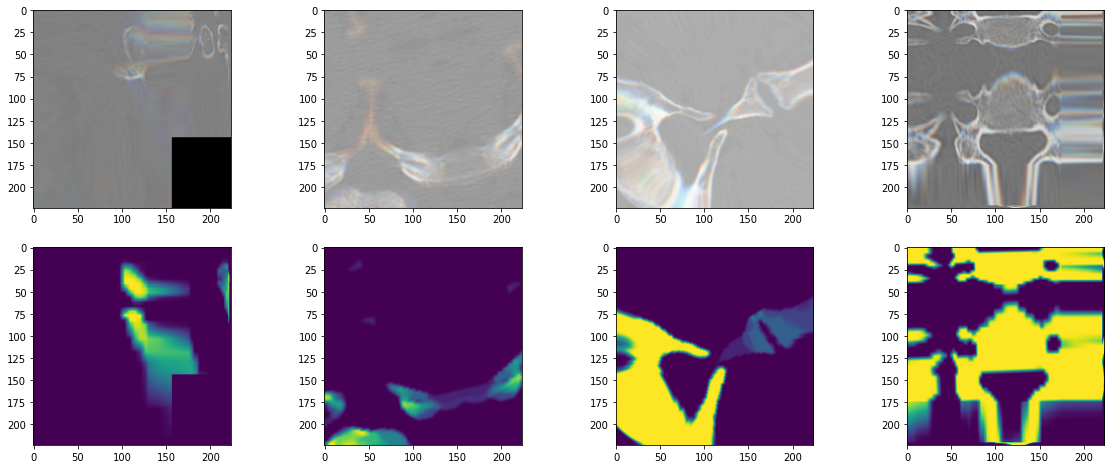

In [33]:
f, axarr = plt.subplots(2,4)
for p in range(4):
    idx = p * 20
    imgs, lbl = dataset_show[idx]
    axarr[0, p].imshow(imgs[7][:3].permute(1, 2, 0))
    axarr[1, p].imshow(imgs[7][-1])

## Model

In [34]:
class TimmModel(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=out_dim,
            features_only=False,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()


        self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=drop_rate, bidirectional=True, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(drop_rate_last),
            nn.LeakyReLU(0.1),
            nn.Linear(256, out_dim),
        )

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs = x.shape[0]
        x = x.view(bs * n_slice_per_c, in_chans, image_size, image_size)
        feat = self.encoder(x)
        feat = feat.view(bs, n_slice_per_c, -1)
        feat, _ = self.lstm(feat)
        feat = feat.contiguous().view(bs * n_slice_per_c, -1)
        feat = self.head(feat)
        feat = feat.view(bs, n_slice_per_c).contiguous()

        return feat


In [35]:
m = TimmModel(backbone)
m(torch.rand(2, n_slice_per_c, in_chans, image_size, image_size)).shape

torch.Size([2, 15])

## Loss & Metric

In [36]:
bce = nn.BCEWithLogitsLoss(reduction='none')


def criterion(logits, targets, activated=False):
    if activated:
        losses = nn.BCELoss(reduction='none')(logits.view(-1), targets.view(-1))
    else:
        losses = bce(logits.view(-1), targets.view(-1))
    losses[targets.view(-1) > 0] *= 2.
    norm = torch.ones(logits.view(-1).shape[0]).to(device)
    norm[targets.view(-1) > 0] *= 2
    return losses.sum() / norm.sum()

## Train & Valid func

In [37]:
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for images, targets in bar:
        optimizer.zero_grad()
        images = images.to(device)
        targets = targets.to(device)
        
        do_mixup = False
        if random.random() < p_mixup:
            do_mixup = True
            images, targets, targets_mix, lam = mixup(images, targets)

        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, targets)
            if do_mixup:
                loss11 = criterion(logits, targets_mix)
                loss = loss * lam  + loss11 * (1 - lam)
        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    gts = []
    outputs = []
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, targets in bar:
            images = images.cuda()
            targets = targets.cuda()

            logits = model(images)
            loss = criterion(logits, targets)
            
            gts.append(targets.cpu())
            outputs.append(logits.cpu())
            valid_loss.append(loss.item())
            
            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')

    outputs = torch.cat(outputs)
    gts = torch.cat(gts)
    valid_loss = criterion(outputs, gts).item()

    return valid_loss


/home/apaddo/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/apaddo/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use cas

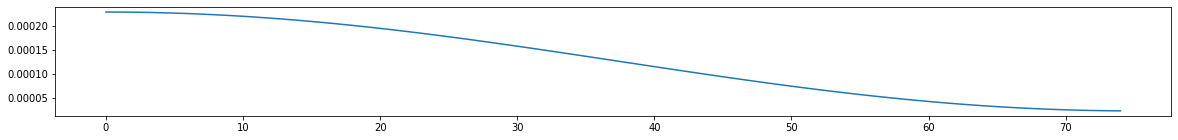

In [38]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, eta_min=eta_min)

lrs = []
for epoch in range(1, n_epochs+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

## Training

In [39]:
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df[df['fold'] != fold].reset_index(drop=True)
    valid_ = df[df['fold'] == fold].reset_index(drop=True)
    dataset_train = CLSDataset(train_, 'train', transform=transforms_train)
    dataset_valid = CLSDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmModel(backbone, pretrained=True)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    scaler = torch.cuda.amp.GradScaler() if use_amp else None

    metric_best = np.inf
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs, eta_min=eta_min)

    model = torch.quantization.convert(model.eval(), inplace=False)
    
    optimizer = torch.optim.SGD(model.parameters(), lr = 23e-5)
    model.qconfig = torch.ao.quantization.get_default_qat_qconfig('fbgemm')
    
    
    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer, scaler)
        valid_loss = valid_func(model, loader_valid)
        metric = valid_loss

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric < metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
#             if not DEBUG:
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()


In [ ]:
run(0)
run(1)
run(2)
run(3)
run(4)

11298 2828
Fri Jan 13 23:54:57 2023 Epoch: 1


  0%|          | 0/354 [00:00<?, ?it/s]/home/apaddo/.local/lib/python3.9/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
smth:0.7385: 100%|██████████| 354/354 [01:29<00:00,  3.93it/s]


Sat Jan 14 00:04:55 2023 Fold 0, Epoch 1, lr: 0.0002300, train loss: 0.51594, valid loss: 0.48765, metric: 0.487648.
metric_best (inf --> 0.487648). Saving model ...
Sat Jan 14 00:04:55 2023 Epoch: 2


smth:0.8288: 100%|██████████| 354/354 [00:51<00:00,  6.84it/s]


Sat Jan 14 00:11:46 2023 Fold 0, Epoch 2, lr: 0.0002300, train loss: 0.46180, valid loss: 0.50635, metric: 0.506349.
Sat Jan 14 00:11:46 2023 Epoch: 3


smth:0.8725: 100%|██████████| 354/354 [00:51<00:00,  6.88it/s]


Sat Jan 14 00:18:02 2023 Fold 0, Epoch 3, lr: 0.0002300, train loss: 0.45845, valid loss: 0.51644, metric: 0.516441.
Sat Jan 14 00:18:03 2023 Epoch: 4


smth:0.8710: 100%|██████████| 354/354 [00:49<00:00,  7.09it/s]


Sat Jan 14 00:24:16 2023 Fold 0, Epoch 4, lr: 0.0002300, train loss: 0.45773, valid loss: 0.51100, metric: 0.511001.
Sat Jan 14 00:24:16 2023 Epoch: 5


smth:0.8742: 100%|██████████| 354/354 [00:47<00:00,  7.40it/s]


Sat Jan 14 00:30:15 2023 Fold 0, Epoch 5, lr: 0.0002300, train loss: 0.45057, valid loss: 0.50673, metric: 0.506732.
Sat Jan 14 00:30:15 2023 Epoch: 6


smth:0.8764: 100%|██████████| 354/354 [00:47<00:00,  7.53it/s]


Sat Jan 14 00:36:16 2023 Fold 0, Epoch 6, lr: 0.0002300, train loss: 0.45160, valid loss: 0.50438, metric: 0.504380.
Sat Jan 14 00:36:16 2023 Epoch: 7


smth:0.8822: 100%|██████████| 354/354 [00:50<00:00,  6.94it/s]


Sat Jan 14 00:42:19 2023 Fold 0, Epoch 7, lr: 0.0002300, train loss: 0.45218, valid loss: 0.50390, metric: 0.503900.
Sat Jan 14 00:42:19 2023 Epoch: 8


smth:0.8894: 100%|██████████| 354/354 [01:17<00:00,  4.56it/s]


Sat Jan 14 00:50:44 2023 Fold 0, Epoch 8, lr: 0.0002300, train loss: 0.44814, valid loss: 0.50219, metric: 0.502191.
Sat Jan 14 00:50:44 2023 Epoch: 9


smth:0.9359: 100%|██████████| 354/354 [01:27<00:00,  4.06it/s]


Sat Jan 14 01:02:26 2023 Fold 0, Epoch 9, lr: 0.0002300, train loss: 0.45207, valid loss: 0.51983, metric: 0.519831.
Sat Jan 14 01:02:27 2023 Epoch: 10


smth:0.8682: 100%|██████████| 354/354 [01:26<00:00,  4.11it/s]


Sat Jan 14 01:14:09 2023 Fold 0, Epoch 10, lr: 0.0002300, train loss: 0.45048, valid loss: 0.49385, metric: 0.493854.
Sat Jan 14 01:14:09 2023 Epoch: 11


smth:0.8845: 100%|██████████| 354/354 [01:25<00:00,  4.14it/s]


Sat Jan 14 01:25:49 2023 Fold 0, Epoch 11, lr: 0.0002300, train loss: 0.44910, valid loss: 0.49927, metric: 0.499270.
Sat Jan 14 01:25:49 2023 Epoch: 12


smth:0.8681: 100%|██████████| 354/354 [01:26<00:00,  4.07it/s]


Sat Jan 14 01:37:36 2023 Fold 0, Epoch 12, lr: 0.0002300, train loss: 0.44808, valid loss: 0.49153, metric: 0.491526.
Sat Jan 14 01:37:36 2023 Epoch: 13


smth:0.8770: 100%|██████████| 354/354 [01:26<00:00,  4.11it/s]


Sat Jan 14 01:49:18 2023 Fold 0, Epoch 13, lr: 0.0002300, train loss: 0.44754, valid loss: 0.49349, metric: 0.493485.
Sat Jan 14 01:49:18 2023 Epoch: 14


smth:0.8880: 100%|██████████| 354/354 [01:26<00:00,  4.11it/s]


Sat Jan 14 02:01:00 2023 Fold 0, Epoch 14, lr: 0.0002300, train loss: 0.44680, valid loss: 0.49504, metric: 0.495038.
Sat Jan 14 02:01:00 2023 Epoch: 15


smth:0.8797: 100%|██████████| 354/354 [01:25<00:00,  4.13it/s]


Sat Jan 14 02:12:40 2023 Fold 0, Epoch 15, lr: 0.0002300, train loss: 0.44555, valid loss: 0.49195, metric: 0.491947.
Sat Jan 14 02:12:40 2023 Epoch: 16


smth:0.8708: 100%|██████████| 354/354 [01:31<00:00,  3.89it/s]


Sat Jan 14 02:24:58 2023 Fold 0, Epoch 16, lr: 0.0002300, train loss: 0.44663, valid loss: 0.49025, metric: 0.490253.
Sat Jan 14 02:24:58 2023 Epoch: 17


smth:0.8773: 100%|██████████| 354/354 [01:28<00:00,  3.99it/s]


Sat Jan 14 02:36:50 2023 Fold 0, Epoch 17, lr: 0.0002300, train loss: 0.44572, valid loss: 0.48976, metric: 0.489763.
Sat Jan 14 02:36:50 2023 Epoch: 18


smth:0.8649: 100%|██████████| 354/354 [01:28<00:00,  3.98it/s]


Sat Jan 14 02:48:46 2023 Fold 0, Epoch 18, lr: 0.0002300, train loss: 0.44378, valid loss: 0.48498, metric: 0.484976.
metric_best (0.487648 --> 0.484976). Saving model ...
Sat Jan 14 02:48:46 2023 Epoch: 19


smth:0.8687: 100%|██████████| 354/354 [01:28<00:00,  3.99it/s]


Sat Jan 14 03:00:39 2023 Fold 0, Epoch 19, lr: 0.0002300, train loss: 0.44529, valid loss: 0.48317, metric: 0.483173.
metric_best (0.484976 --> 0.483173). Saving model ...
Sat Jan 14 03:00:39 2023 Epoch: 20


smth:0.8821: 100%|██████████| 354/354 [01:28<00:00,  4.01it/s]


Sat Jan 14 03:12:34 2023 Fold 0, Epoch 20, lr: 0.0002300, train loss: 0.44438, valid loss: 0.49001, metric: 0.490014.
Sat Jan 14 03:12:34 2023 Epoch: 21


smth:0.4568:  50%|████▉     | 701/1412 [05:11<05:08,  2.30it/s]

In [ ]:
run(1)

In [ ]:
run(2)

In [ ]:
run(3)

In [ ]:
run(4)